In [1]:

import numpy as np
import os
import random
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import json
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



2022-01-20 14:46:30.496176: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
#Configure GPU 
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2022-01-20 14:46:34.098740: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-20 14:46:34.100085: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-20 14:46:34.135693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 14:46:34.135864: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.468GHz coreCount: 5 deviceMemorySize: 1.94GiB deviceMemoryBandwidth: 104.43GiB/s
2022-01-20 14:46:34.135906: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-20 14:46:34.178652: I tensorflow/stream_executor/platform/def

In [3]:
# Constants

TRAIN_1 = 'train_1'
TRAIN_2 = 'train_2'
TEST = 'test'

IMG_WIDTH=96
IMG_HEIGHT=96

CLASS_DICT = {'junk': 0, 
              'cup': 1, 
              'bowl': 2, 
              'decorative': 3}

CLASS_KEY = {0:'junk',
             1:'cup',
             2:'bowl',
             3:'decorative'}

# Random visual sampling of classes

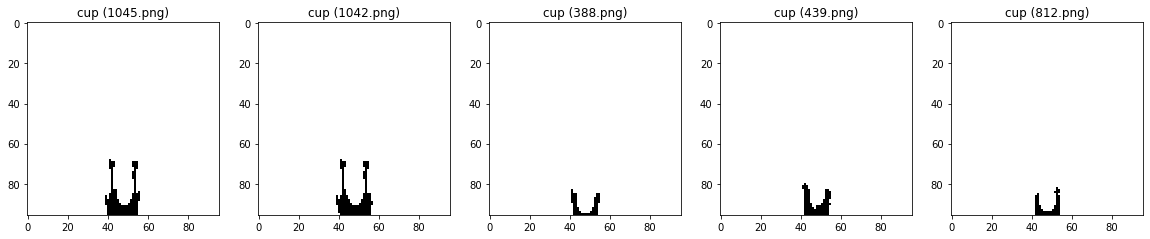

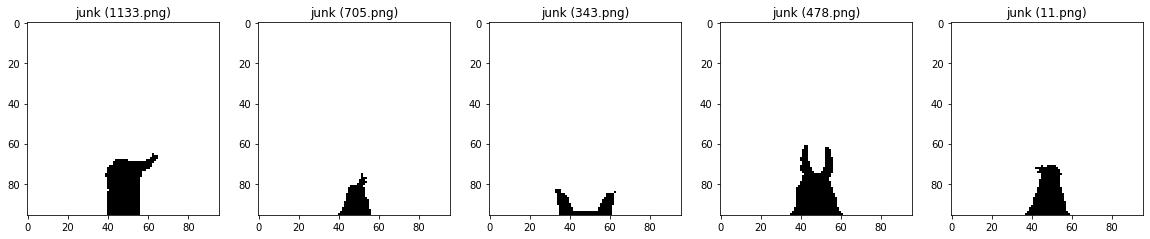

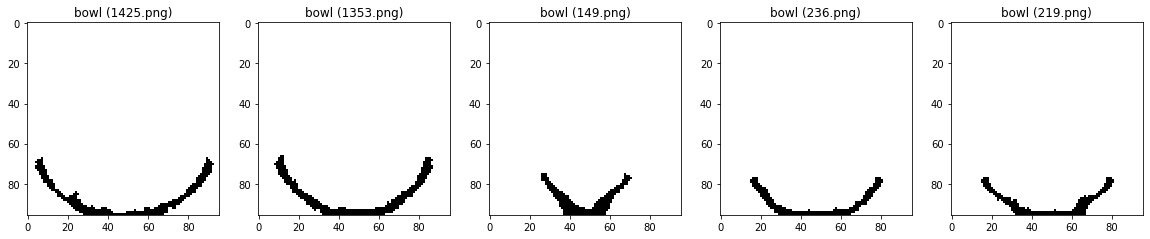

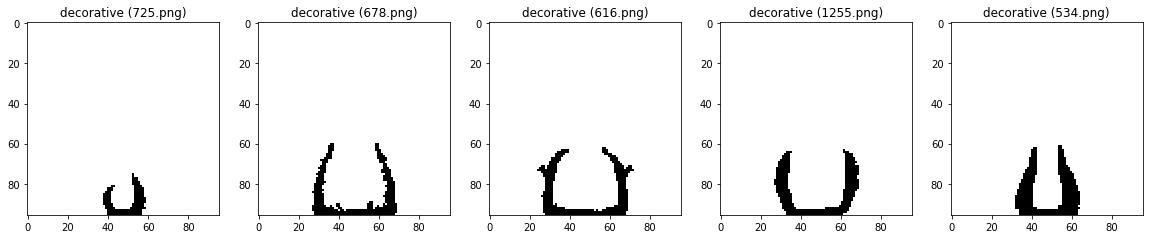

In [4]:
def display_class_samples(root_dir):
    for folder in os.listdir(root_dir):  
        folder_path = os.path.join(root_dir, folder)
        if os.path.isdir(folder_path):
            
            plt.figure(figsize=(20,20))
            for i in range(5):
                file = random.choice(os.listdir(folder_path))
                image_path= os.path.join(folder_path, file)
                img=mpimg.imread(image_path)
                ax=plt.subplot(1,5,i+1)
                ax.title.set_text(f'{folder} ({file})')
                plt.imshow(img,interpolation='nearest')

display_class_samples(TEST)

# Helper functions

In [5]:
def create_dataset(img_folder, random_seed=42):
    img_data_array=[]
    class_name=[]
   
    for directory in os.listdir(img_folder):
        if os.path.isdir(os.path.join(img_folder, directory)):
            
            for file in os.listdir(os.path.join(img_folder, directory)):
            
                image_path= os.path.join(img_folder, directory,  file)
                image= cv2.imread( image_path, cv2.IMREAD_GRAYSCALE)
                image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
                image=np.array(image)
                image = image.astype('float32')
                image /= 255 
                img_data_array.append(image)
                class_name.append(CLASS_DICT[directory])
                
    
    return shuffle(np.array(img_data_array), np.array(class_name), random_state=random_seed)


In [6]:
def save_weights_and_biases(model, file):
    json_string = []
    for i in range(len(model.layers)):
        weights_biases = []
        for k in range(len(model.layers[i].get_weights())):
            weights_biases.append(model.layers[i].get_weights()[k].tolist())
        json_string.append({'config': model.layers[i].get_config(), 'weights_biases': weights_biases})

    with open(f'{file}.json', 'w', encoding='utf-8') as f:
        json.dump(json_string, f, ensure_ascii=False, indent=3)

In [22]:
def display_false_classifications(true, predict, images, limit=50):
        displayed = 0
        
        for i in range(len(true)):
                if displayed >= limit: return
                if true[i] != predict[i]:
                        displayed+=1
                        plt.imshow(images[i],interpolation='nearest',cmap='Greys_r')
                        plt.title(f'TRUE: {CLASS_KEY[true[i]]} | PREDICT: {CLASS_KEY[predict[i]]}')
                        plt.show()

In [8]:
def display_confusion_matrix(true, predict):
    cm = confusion_matrix(true, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['junk','cup','bowl','decorative']
                              )
    disp.plot()

    plt.show()

# model_1

optimized to be as small as possible to avoid lag during game random seeding is used to avoid model getting stuck on benchmark results

In [105]:
# Get train and test data, shuffle it.
X_train_data, y_train_data = create_dataset(TRAIN_1)
X_test_data, y_test_data = create_dataset(TEST)
# Reshape train data into tensor form
X_train = X_train_data.reshape(X_train_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
X_test = X_test_data.reshape(X_test_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
# Reshape test data into categorical form
y_train = to_categorical(y_train_data)
y_test = to_categorical(y_test_data)

In [26]:
tf.random.set_seed(80)

classifier = Sequential()

classifier.add(Convolution2D(filters=5, kernel_size=2, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT,IMG_WIDTH, 1)))
classifier.add(MaxPooling2D((2, 2)))
classifier.add(Flatten())
classifier.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
classifier.add(Dense(4, activation='softmax'))

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [27]:
history = classifier.fit(x=X_train, 
                         y=y_train, 
                         batch_size=10,
                         epochs=3, 
                         verbose=1,
                         validation_data=(X_test,y_test)
                        )   

Epoch 1/3
678/678 [==============================] - 2s 3ms/step - loss: 0.8812 - accuracy: 0.6357 - val_loss: 0.4009 - val_accuracy: 0.8367
Epoch 2/3
678/678 [==============================] - 2s 3ms/step - loss: 0.2594 - accuracy: 0.9115 - val_loss: 0.4061 - val_accuracy: 0.8387
Epoch 3/3
678/678 [==============================] - 2s 3ms/step - loss: 0.1813 - accuracy: 0.9345 - val_loss: 0.4463 - val_accuracy: 0.8354


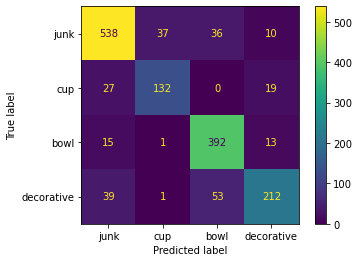

In [30]:
predictions = classifier.predict_classes(X_test)
display_confusion_matrix(y_test_data, predictions)


In [34]:
save_weights_and_biases(classifier, 'model_1')

In [ ]:

                
display_false_classifications(y_test_data, predictions, X_test)



# model_2

In [84]:
# Get train and test data, shuffle it.
X_train_data, y_train_data = create_dataset(TRAIN_2)
X_test_data, y_test_data = create_dataset(TEST)
# Reshape train data into tensor form
X_train = X_train_data.reshape(X_train_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
X_test = X_test_data.reshape(X_test_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
# Reshape test data into categorical form
y_train = to_categorical(y_train_data)
y_test = to_categorical(y_test_data)

In [85]:
tf.random.set_seed(1234512345345)

classifier = Sequential()

classifier.add(Convolution2D(filters=5, kernel_size=2, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT,IMG_WIDTH, 1)))
classifier.add(MaxPooling2D((2, 2)))
classifier.add(Flatten())
classifier.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
classifier.add(Dense(4, activation='softmax'))

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [86]:
history = classifier.fit(x=X_train, 
                         y=y_train, 
                         batch_size=10,
                         epochs=4, 
                         verbose=1,
                         validation_data=(X_test,y_test)
                        )   

Epoch 1/4
516/516 [==============================] - 2s 4ms/step - loss: 0.6339 - accuracy: 0.7835 - val_loss: 0.5649 - val_accuracy: 0.8407
Epoch 2/4
516/516 [==============================] - 2s 3ms/step - loss: 0.1456 - accuracy: 0.9537 - val_loss: 0.6678 - val_accuracy: 0.8348
Epoch 3/4
516/516 [==============================] - 2s 3ms/step - loss: 0.1016 - accuracy: 0.9681 - val_loss: 0.6049 - val_accuracy: 0.8420
Epoch 4/4
516/516 [==============================] - 2s 3ms/step - loss: 0.0792 - accuracy: 0.9724 - val_loss: 0.6078 - val_accuracy: 0.8420


/home/owen/Programs/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


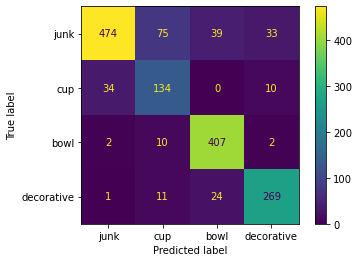

In [87]:
predictions = classifier.predict_classes(X_test)
display_confusion_matrix(y_test_data, predictions)

In [88]:
save_weights_and_biases(classifier, 'model_2')

In [ ]:
display_false_classifications(y_test_data, predictions, X_test)

# model_3

In [10]:
# Get train and test data, shuffle it.
X_1, y_1 = create_dataset(TRAIN_1)
X_2, y_2 = create_dataset(TRAIN_2)

X_train_data = np.concatenate((X_1, X_2))
y_train_data = np.concatenate((y_1, y_2))

shuffle(X_train_data, y_train_data, random_state=42)

X_test_data, y_test_data = create_dataset(TEST)
# Reshape train data into tensor form
X_train = X_train_data.reshape(X_train_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
X_test = X_test_data.reshape(X_test_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
# Reshape test data into categorical form
y_train = to_categorical(y_train_data)
y_test = to_categorical(y_test_data)

In [ ]:
tf.random.set_seed(1234512345345)

classifier = Sequential()

classifier.add(Convolution2D(filters=5, kernel_size=2, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT,IMG_WIDTH, 1)))
classifier.add(MaxPooling2D((2, 2)))
classifier.add(Flatten())
classifier.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
classifier.add(Dense(4, activation='softmax'))

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:
history = classifier.fit(x=X_train, 
                         y=y_train, 
                         batch_size=10,
                         epochs=10, 
                         verbose=1,
                         validation_data=(X_test,y_test)
                        )   

2022-01-20 14:17:59.693589: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 439713792 exceeds 10% of free system memory.
2022-01-20 14:17:59.896622: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-20 14:17:59.918294: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3999980000 Hz


Epoch 1/10


2022-01-20 14:18:00.292564: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-20 14:18:00.773539: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


1193/1193 [==============================] - 7s 3ms/step - loss: 0.5361 - accuracy: 0.8077 - val_loss: 0.5013 - val_accuracy: 0.8275
Epoch 2/10
1193/1193 [==============================] - 4s 3ms/step - loss: 0.1611 - accuracy: 0.9445 - val_loss: 0.4635 - val_accuracy: 0.8466
Epoch 3/10
1193/1193 [==============================] - 4s 3ms/step - loss: 0.1226 - accuracy: 0.9561 - val_loss: 0.4717 - val_accuracy: 0.8590
Epoch 4/10
1193/1193 [==============================] - 4s 3ms/step - loss: 0.0873 - accuracy: 0.9718 - val_loss: 0.5724 - val_accuracy: 0.8446
Epoch 5/10
1193/1193 [==============================] - 4s 3ms/step - loss: 0.0762 - accuracy: 0.9758 - val_loss: 0.6158 - val_accuracy: 0.8518
Epoch 6/10
1193/1193 [==============================] - 4s 3ms/step - loss: 0.0684 - accuracy: 0.9733 - val_loss: 0.5784 - val_accuracy: 0.8505
Epoch 7/10
1193/1193 [==============================] - 4s 3ms/step - loss: 0.0470 - accuracy: 0.9863 - val_loss: 0.7044 - val_accuracy: 0.8518
Epo

/home/owen/Programs/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


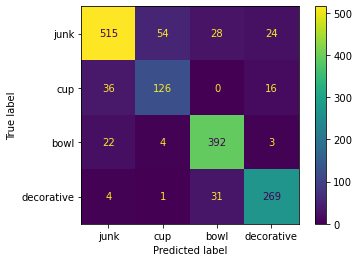

In [13]:
predictions = classifier.predict_classes(X_test)
display_confusion_matrix(y_test_data, predictions)

In [14]:
save_weights_and_biases(classifier, 'model_3')

In [ ]:
display_false_classifications(y_test_data, predictions, X_test)

# model_4

In [9]:
# Get train and test data, shuffle it.
X_1, y_1 = create_dataset(TRAIN_1)
X_2, y_2 = create_dataset(TEST)

X_train_data = np.concatenate((X_1, X_2))
y_train_data = np.concatenate((y_1, y_2))

shuffle(X_train_data, y_train_data, random_state=42)

X_test_data, y_test_data = create_dataset(TRAIN_2)
# Reshape train data into tensor form
X_train = X_train_data.reshape(X_train_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
X_test = X_test_data.reshape(X_test_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
# Reshape test data into categorical form
y_train = to_categorical(y_train_data)
y_test = to_categorical(y_test_data)

In [19]:
tf.random.set_seed(1234512345345)

classifier = Sequential()

classifier.add(Convolution2D(filters=5, kernel_size=2, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT,IMG_WIDTH, 1)))
classifier.add(MaxPooling2D((2, 2)))
classifier.add(Flatten())
classifier.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
classifier.add(Dense(4, activation='softmax'))

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [20]:
history = classifier.fit(x=X_train, 
                         y=y_train, 
                         batch_size=10,
                         epochs=3, 
                         verbose=1,
                         validation_data=(X_test,y_test)
)

Epoch 1/3
830/830 [==============================] - 4s 4ms/step - loss: 0.5871 - accuracy: 0.7915 - val_loss: 0.8267 - val_accuracy: 0.7480
Epoch 2/3
830/830 [==============================] - 3s 4ms/step - loss: 0.1488 - accuracy: 0.9462 - val_loss: 1.4492 - val_accuracy: 0.6607
Epoch 3/3
830/830 [==============================] - 3s 4ms/step - loss: 0.1004 - accuracy: 0.9625 - val_loss: 1.0631 - val_accuracy: 0.7581


/home/owen/Programs/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


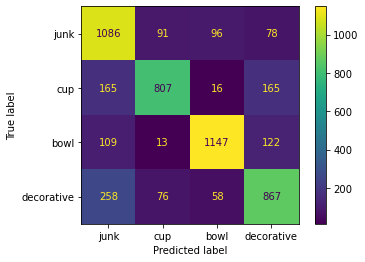

In [21]:
predictions = classifier.predict_classes(X_test)
display_confusion_matrix(y_test_data, predictions)


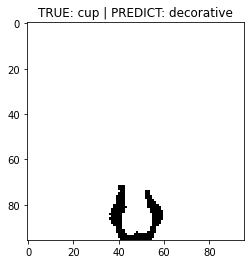

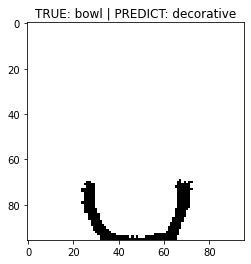

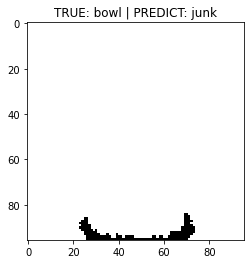

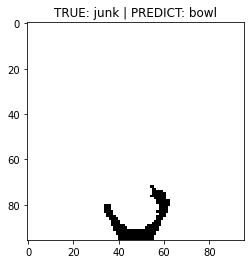

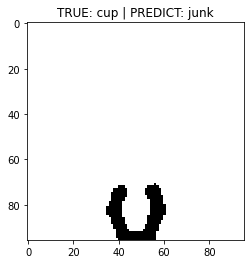

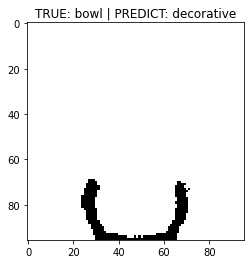

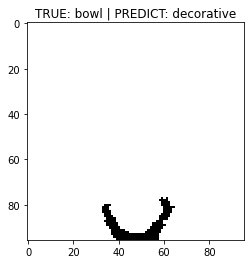

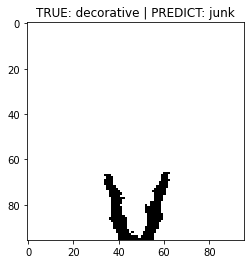

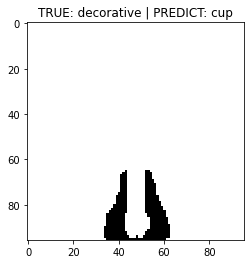

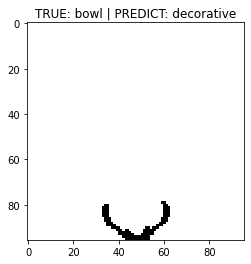

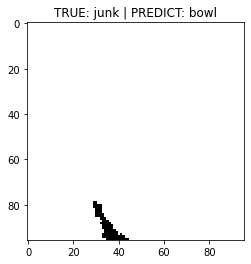

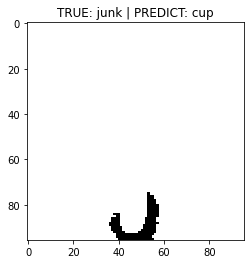

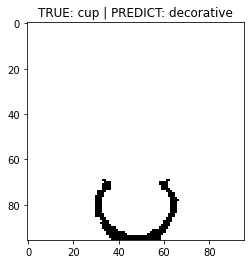

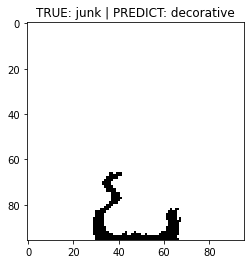

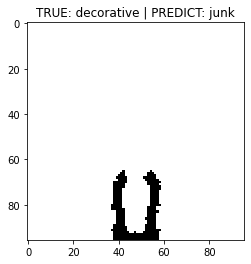

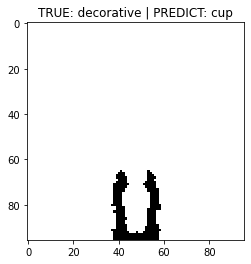

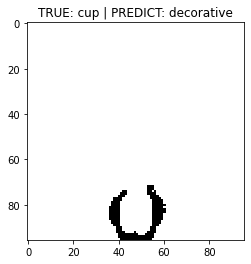

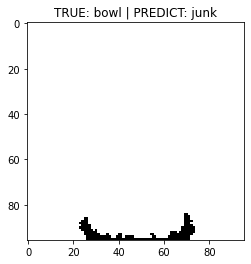

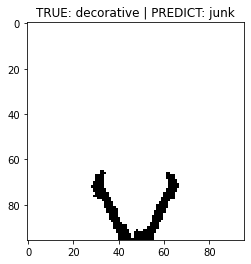

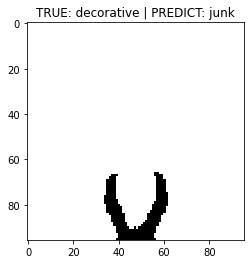

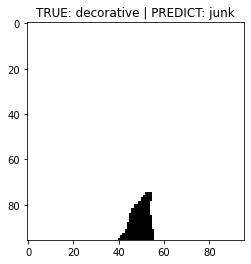

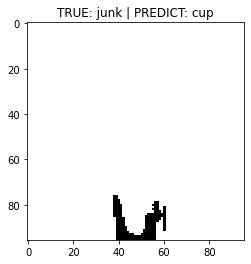

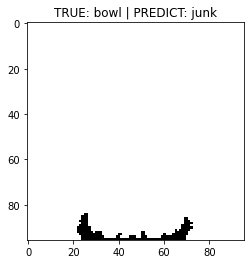

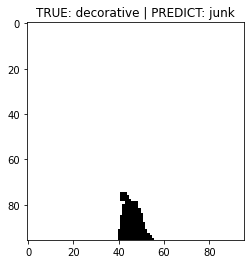

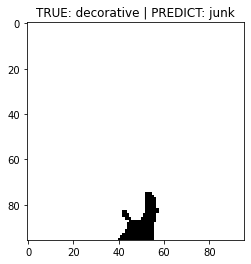

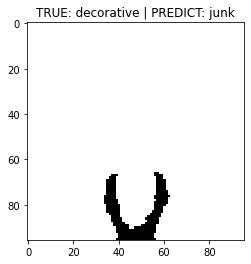

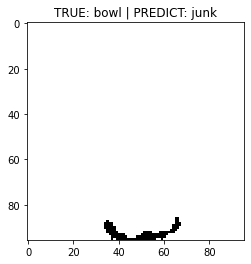

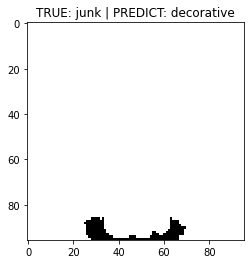

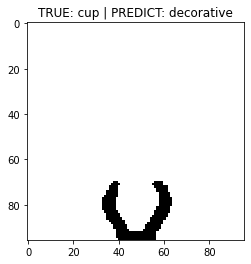

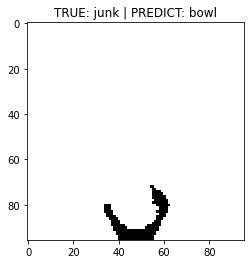

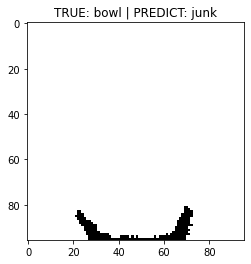

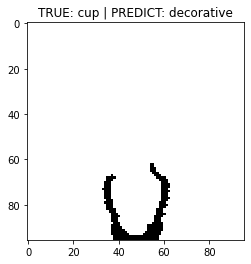

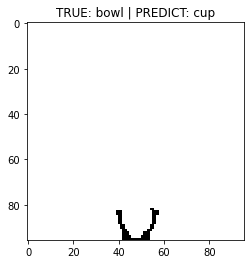

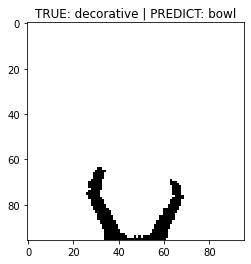

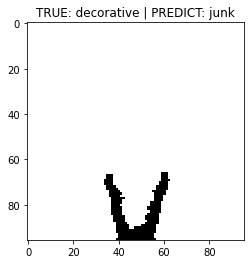

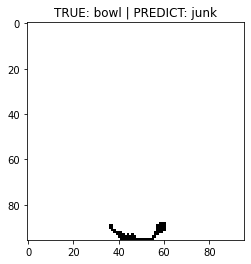

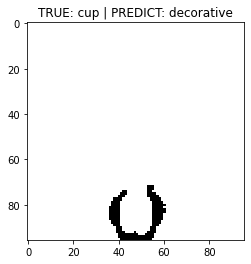

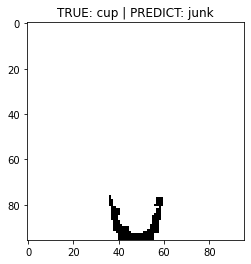

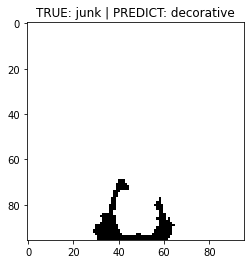

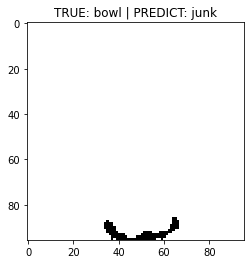

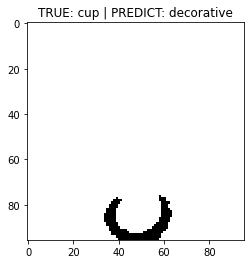

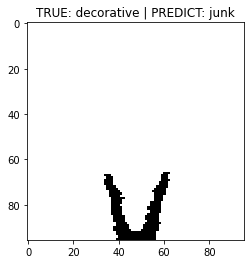

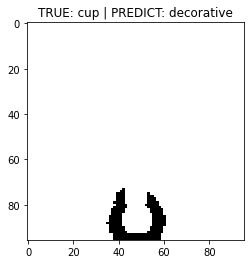

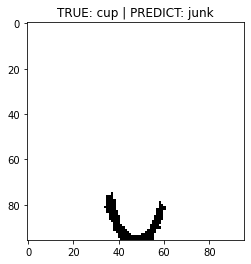

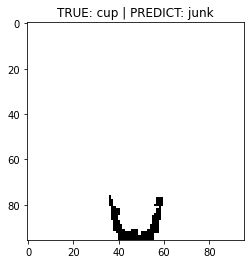

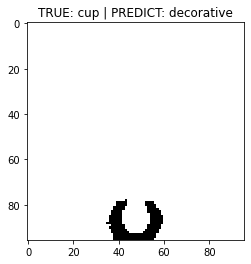

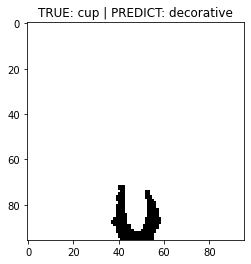

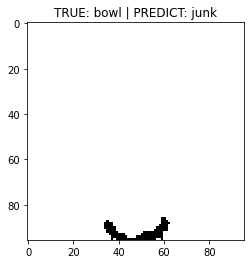

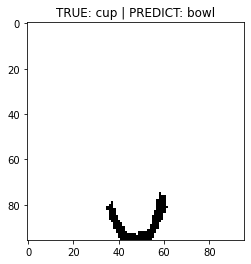

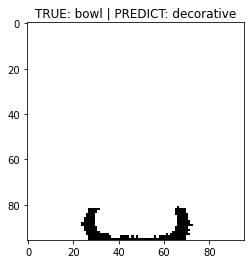

In [24]:
display_false_classifications(y_test_data, predictions, X_test, 200)